In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
df = pd.read_csv("ParisHousing.csv")

# Display basic information and first few rows
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [3]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64


In [4]:
# Summary statistics
print(df.describe())

       squareMeters  numberOfRooms       hasYard       hasPool        floors  \
count   10000.00000   10000.000000  10000.000000  10000.000000  10000.000000   
mean    49870.13120      50.358400      0.508700      0.496800     50.276300   
std     28774.37535      28.816696      0.499949      0.500015     28.889171   
min        89.00000       1.000000      0.000000      0.000000      1.000000   
25%     25098.50000      25.000000      0.000000      0.000000     25.000000   
50%     50105.50000      50.000000      1.000000      0.000000     50.000000   
75%     74609.75000      75.000000      1.000000      1.000000     76.000000   
max     99999.00000     100.000000      1.000000      1.000000    100.000000   

           cityCode  cityPartRange  numPrevOwners         made    isNewBuilt  \
count  10000.000000   10000.000000   10000.000000  10000.00000  10000.000000   
mean   50225.486100       5.510100       5.521700   2005.48850      0.499100   
std    29006.675799       2.872024     

In [5]:
# Label Encoding for categorical variable 'made'
label_encoder = LabelEncoder()
df['made'] = label_encoder.fit_transform(df['made'])

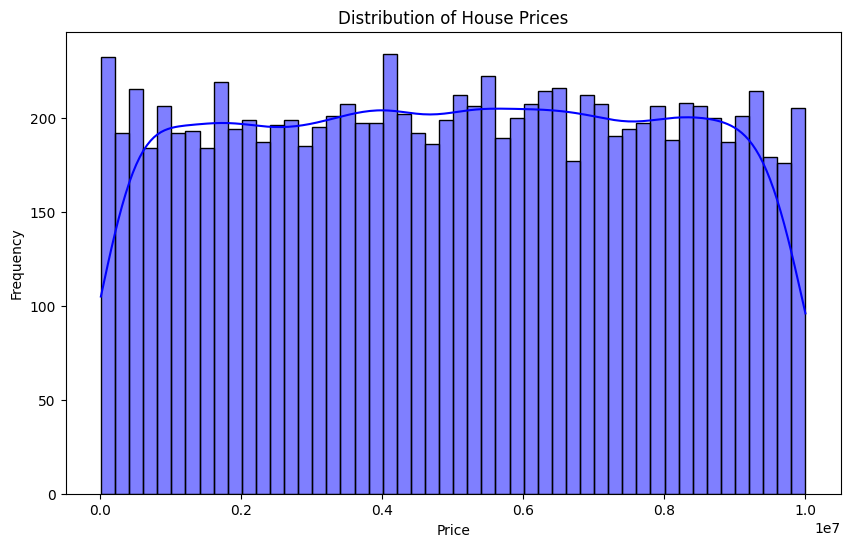

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

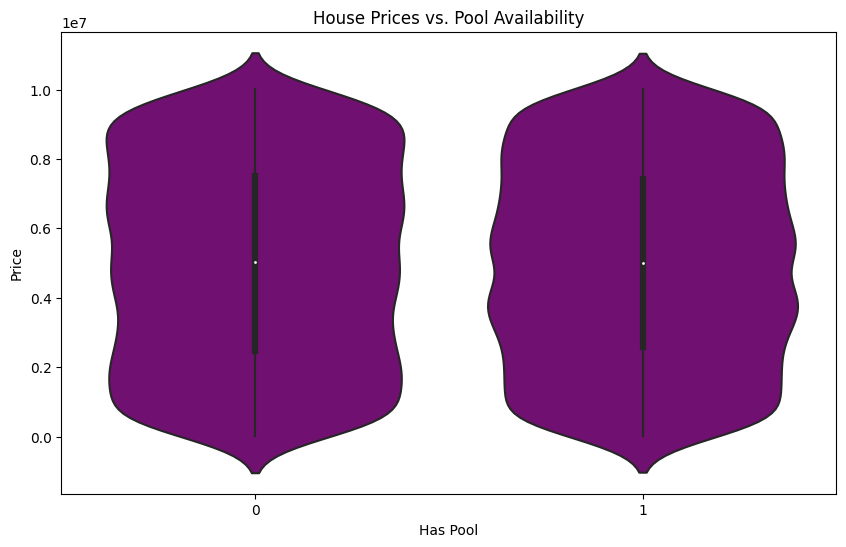

In [7]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=df['hasPool'], y=df['price'], color='purple')
plt.title("House Prices vs. Pool Availability")
plt.xlabel("Has Pool")
plt.ylabel("Price")
plt.show()

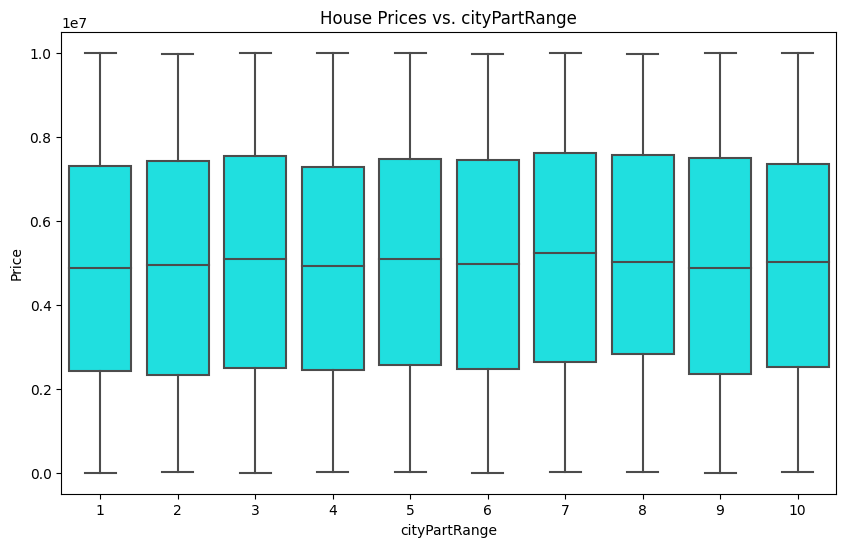

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['cityPartRange'], y=df['price'], color='cyan')
plt.title("House Prices vs. cityPartRange")
plt.xlabel("cityPartRange")
plt.ylabel("Price")
plt.show()

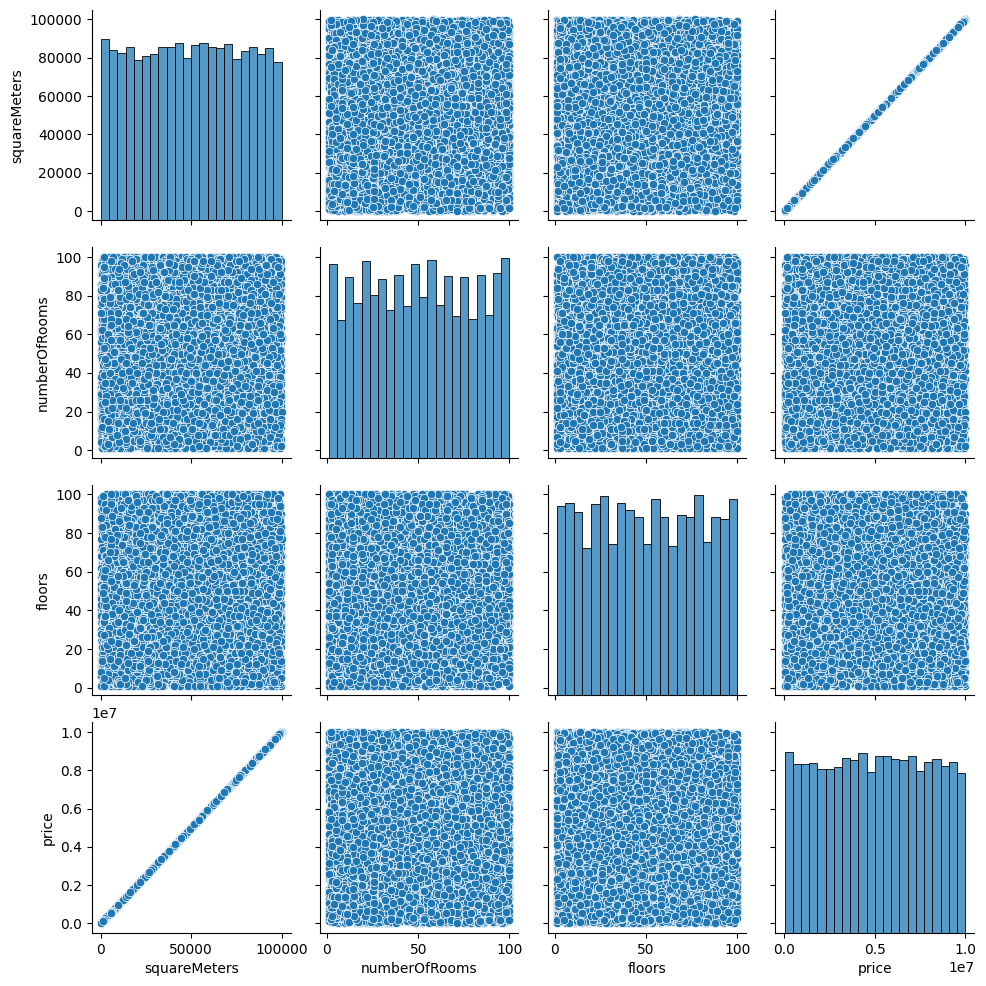

In [9]:
# Pairplot for selected numerical features
selected_numeric_features = ['squareMeters', 'numberOfRooms', 'floors', 'price']
sns.pairplot(df[selected_numeric_features])
plt.show()

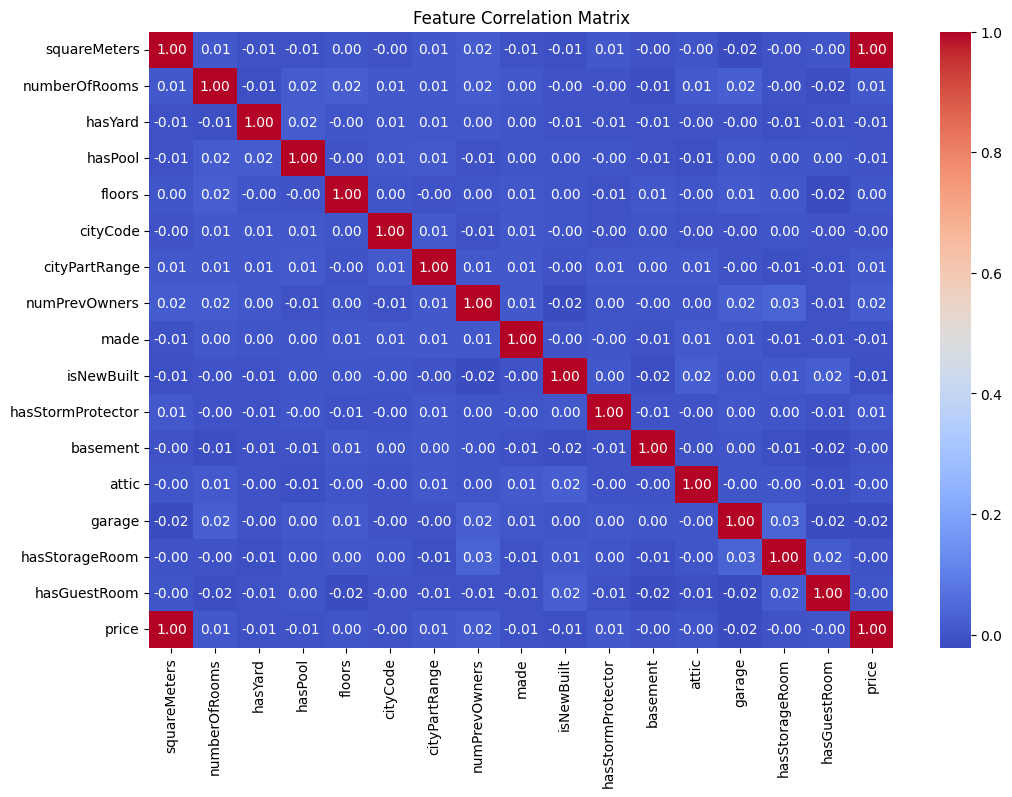

In [10]:
# Check correlations with target variable 'price'
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [11]:
# Feature Selection using Mutual Information Regression
X = df.drop(columns=['price'])
y = df['price']
selector = SelectKBest(score_func=mutual_info_regression, k=10)  # Select top 10 features
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features using Mutual Information Regression:", selected_features)

Selected Features using Mutual Information Regression: Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'numPrevOwners', 'isNewBuilt', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')


In [14]:
# Feature Scaling
scaler = StandardScaler()
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
X_scaled = pd.DataFrame(scaler.fit_transform(X_selected_df), columns=selected_features)

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [21]:
# Model Training and Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mae, rmse, r2

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor()
}

results = {}
for name, model in models.items():
    mae, rmse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R2: {r2}")

Linear Regression - MAE: 1513.3890110219968, RMSE: 1925.9808894298235, R2: 0.9999995764920989
Decision Tree - MAE: 4188.015900000014, RMSE: 5338.217515416559, R2: 0.9999967465053128
Random Forest - MAE: 3085.1052404999705, RMSE: 3875.6321561907175, R2: 0.999998285084715
XGBoost - MAE: 6290.7950823242045, RMSE: 8190.539925038639, R2: 0.9999923408137


In [24]:
# Hyperparameter Tuning for Linear Regression
param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1, None]
}

grid_search_lr = GridSearchCV(LinearRegression(), param_grid_lr, cv=5, scoring='r2', n_jobs=1)
grid_search_lr.fit(X_train, y_train)
best_linear_model = grid_search_lr.best_estimator_
print("Best Linear Regression Parameters:", grid_search_lr.best_params_)

Best Linear Regression Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}


In [25]:
# Evaluate the best Linear Regression model
y_pred_best = best_linear_model.predict(X_test)
best_mae = mean_absolute_error(y_test, y_pred_best)
best_mse = mean_squared_error(y_test, y_pred_best)
best_rmse = np.sqrt(best_mse)
best_r2 = r2_score(y_test, y_pred_best)

print(f"Tuned Linear Regression - MAE: {best_mae}, MSE: {best_mse}, RMSE: {best_rmse}, R2: {best_r2}")

Tuned Linear Regression - MAE: 1513.336990069057, MSE: 3709096.2228768095, RMSE: 1925.9014052844993, R2: 0.9999995765270541


In [30]:
y_pred_best

array([7962395.11724375, 3716115.65645864, 8553644.78079739, ...,
       1951505.92595011, 2945375.74481266, 7042747.61396354])

C:\Users\kaviy\anaconda3\envs\priceprediction\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='price', ylabel='Density'>

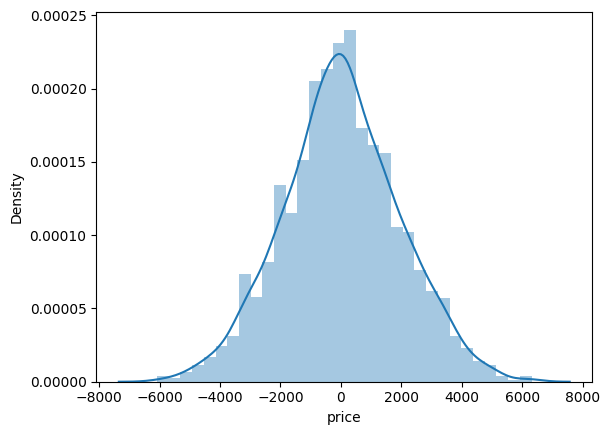

In [31]:
sns.distplot(y_test-y_pred_best)

In [29]:
import joblib

# Save the tuned Linear Regression model
joblib.dump(best_linear_model, "best_linear_model.pkl")

['best_linear_model.pkl']